In [1]:
from tifffile import TiffFile
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from scipy import optimize
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import binary_opening
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func

from readlif.reader import LifFile
import skimage


save_folder = '.'
import glob
import alienlab.plot
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
#p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

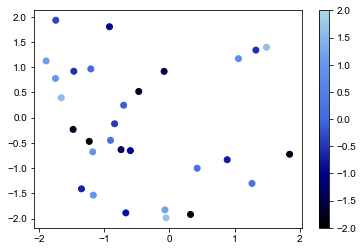

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [-2., -1,0, 1, 2]
colors = ["k","darkblue","royalblue", 'cornflowerblue', 'lightblue']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
blue_map = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.scatter(x,y,c=c, cmap=blue_map, norm=norm)
plt.colorbar()
plt.show()

In [3]:
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0


def simple_tau(fluo, time_array, sample_rate = 0):
    L = len(time_array) 
    if sample_rate==0:
        sample_rate = L/(time_array[-1]-time_array[0])
    fluo_transition = fluo
    time_transition = np.linspace(0, L - 1, L)
    x0 = [1e5, L/8, 1]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition, fluo_transition, exp_decay))
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]

    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  L//10: #if too high
        tau =  L//10
    if tau < 3: #if too low, increase it
        tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
    parameters_estimated = OptimizeResult.x
    parameters_estimated[1]/=sample_rate

    return parameters_estimated


@delayed
@wrap_non_picklable_objects
def simple_tau_parallel(fluo, time_array, sample_rate = 5):
    return simple_tau(fluo, time_array, sample_rate)[1]


D = 3


def LIF_ImgAndInfo (FilePath, StackNumber):
    ImageStacksObject = LifFile(FilePath)
    ImageStack = ImageStacksObject.get_image(StackNumber)    # Get the frames in the stack and save as a list of numpy arrays
    ImageStackNumpy = []
    for i in range (ImageStacksObject.image_list[StackNumber]['dims'][3]):        
        IMG = ImageStack.get_frame(z=0, t=i, c=0)
        IMGnumpy = np.array(IMG)
        ImageStackNumpy.append(IMGnumpy)    ## Get name, laser power and dwell time
    Name = ImageStacksObject.image_list[StackNumber]['name']
    PixelDwellTime = ImageStacksObject.image_list[1]['settings']['PixelDwellTime']
    Zoom = ImageStacksObject.image_list[StackNumber]['settings']['Zoom']    
    return np.array(ImageStackNumpy), Name, PixelDwellTime, Zoom


    

def plot_map(I_000, I_000_map, save_name, limits = (0,0), tau = False):
    """display the results"""
    
    #crop the outliers for correct scaling of the colormap
    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.01)
        Q3 = np.quantile(I_000, 0.995)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    
    
    #map of intensities
    f = p.set_figure()
    if tau == False:
        image = plt.imshow((I_000_map), cmap = blue_map)
        
    else:
        image = plt.imshow((I_000_map), cmap = "viridis")

    H, L = I_000_map.shape
    scale = H//6
    rec = matplotlib.patches.Rectangle((H-H//4, L-L//11), scale, L//70, color = "lightgrey")
    ax = plt.gca()
    ax.add_patch(rec)
    
    plt.axis("off")
    divider = make_axes_locatable(plt.gca())
    axdef = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
    ax = plt.gca()
    ax.tick_params(labelsize=p.fonttick)
    if tau==False:
        plt.xlabel(r"$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)", size = p.fontsize)
    else:
        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)",  size = p.fontsize)

    plt.savefig(p.save_folder + "/" +save_name + p.extension)
    
    
    # histogram of intensities
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()

    
    if tau==False:
        fig = p.set_figure("%d", "%d")

        plt.xlabel(r"$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)")
    else:
        fig = p.set_figure("%0.1f", "%d")

        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)")
    ax = plt.gca()

    plt.ylabel("")
    ax.tick_params(axis='both', which='major', direction = 'in', top = True, right = True)
    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    plt.savefig(p.save_folder + "/hist_" + save_name + p.extension)
    
    np.savetxt(p.save_folder + "/" + save_name + ".csv", I_000_map, delimiter=",")


    return I_000_map, I_000_distrib

In [4]:
file = glob.glob("../data/confocalX/*.lif")[0]
k = 5
volume, Name, PixelDwellTime, Zoom = LIF_ImgAndInfo(file, k)


In [5]:
float(PixelDwellTime)*1e6

4.875

9.803326489967546
../data/confocalX\Sequence Activation Reading Dronpa.lif


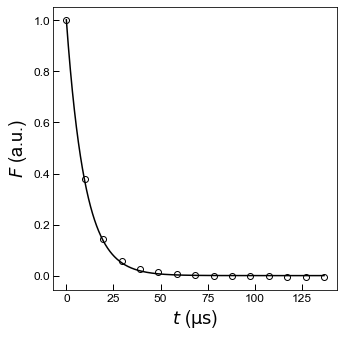

<Figure size 432x288 with 0 Axes>

In [6]:

fig = p.set_figure("%d", "%0.1f")    


name = os.path.split(file)[1][:-4]

K = 5
D = 2 #downscale
dwell_time = 4.88e-6 #sec

for j, k in enumerate([5]):
    video, Name, PixelDwellTime, Zoom = LIF_ImgAndInfo(file, k)

    time = np.linspace(0, len(video)-1, len(video))*dwell_time #generate time array from framerate


    v_ref = np.mean(volume[0:K], axis = 0)
    mask = v_ref>np.mean(v_ref)


    im_ref = downscale_local_mean(v_ref, (D, D))


    if k==5:
        mask = im_ref > np.mean(im_ref)
        mask = binary_opening(mask)

    else:
        dx = lsm_metadata["DimensionX"]
        dy  = lsm_metadata["DimensionY"]
        px = lsm_metadata["VoxelSizeX"]
        S = 3*1e-6//px + 1
        mask = np.zeros((im_ref.shape))
        V = 2*D
        mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
        mask = mask.astype(bool)


    video = np.copy(volume)
    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]

    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

    to_evaluate = video_downscaled[:,mask.flatten()]

    x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
    y= np.mean(to_evaluate, axis = 1)
    m = np.mean(y[-20:])
    y=(y-m)/(y[0]-m)

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])
    print(file)
    K=2
    y=y[::K]
    x=x[::K]
    x2 = np.linspace(x.min(), x.max(), 1024)
    plt.plot(x2, exp_decay(params, x2), 'k')
    plt.plot(x, y, marker = ["o", "^"][j], markeredgecolor="k", color="none",
            label = "dwell_time: %0.1e s "%(dwell_time))
    plt.xlabel(r"$t$ ($\mathrm{\mu s}$)")
    plt.ylabel(r"$F$ (a.u.)")
    p.save_name ="solution_3_mean_time_response"
    p.saving(fig)



In [7]:
def crop(im, x,y):
    L,H =im.shape
    dl = int((L-x*L)//2)
    dh = int((H-y*H)//2)
    print(dl, dh)
    im = im[dl:L-dl,dh:H-dh]
    return im


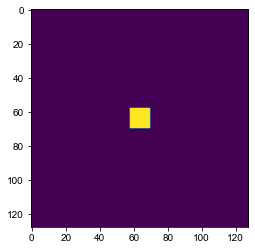

In [8]:
dx = 256
dy  = 256
dp = 290/256*1e-6
S = 30*1e-6/dp + 1
mask = np.zeros((im_ref.shape))
V = 2*D
mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1

plt.figure()
plt.imshow(mask)

(78, 75)
(30, 5850)
29.069483231618825
(78, 75)
(30, 5850)
10.171954513661765


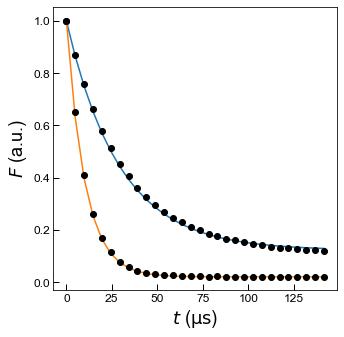

<Figure size 432x288 with 0 Axes>

In [9]:

fig = p.set_figure("%d", "%0.1f")
ax = plt.gca()
plt.xlabel('$t$ ($\mathrm{\mu s}$)')
plt.ylabel("$F$ (a.u.)")



for j, k in enumerate([58, 5]):
    name = os.path.split(file)[1][:-4] + "_%d"%k
    plt.close('all')
    K = 5
    D = 2
    volume, Name, PixelDwellTime, Zoom = LIF_ImgAndInfo(file, k)
    volume = volume[:,100:256, 50:200]

    time = np.linspace(0, len(video)-1, len(video))*dwell_time #generate time array from framerate
    v_ref = np.mean(volume[0:K], axis = 0)
    mask = v_ref>np.mean(v_ref)


    im_ref = downscale_local_mean(v_ref, (D, D))


    
    if k in [5, 2, 28]:

        im_ref = downscale_local_mean(np.mean(volume[0:K], axis = 0), (D, D))

        threshold = skimage.filters.threshold_li(im_ref) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
        #select it from the image that best matches a mask, and copy the corresponding function name printed above

        mask = im_ref>threshold
        mask = binary_opening(mask,  np.ones((k,k)))


    else:
        dx = 256
        dy  = 256
        dp = 290/256*1e-6
        S = 200*1e-6/dp + 1
        mask = np.zeros((im_ref.shape))
        V = 2*D
        mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1

        mask = mask.astype(bool)
        p.save_name = name  +  "_mask_ref"
        p.saving(fig)

    video = np.copy(volume)
    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]

    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)
    print(mask.shape)
    print(video_downscaled.shape)
    to_evaluate = video_downscaled[:,mask.flatten()]
    
   
    x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
    y= np.mean(to_evaluate, axis = 1)
    y/=y[0]

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])
    ax.plot(x, exp_decay(params, x))
    ax.plot(x, y, "ok",
            label = "dwell_time: %0.1e s "%(dwell_time))
    
p.save_name = name + "_mean_time_response"
p.saving(fig)



In [10]:
volume.shape

(30, 156, 150)

256 256
(52, 50)
(30, 2600)
10.196740759996306


100%|███████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 809.05it/s]


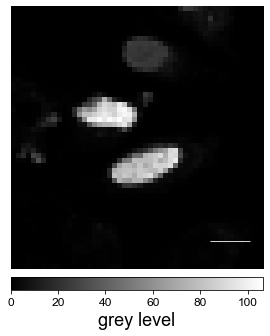

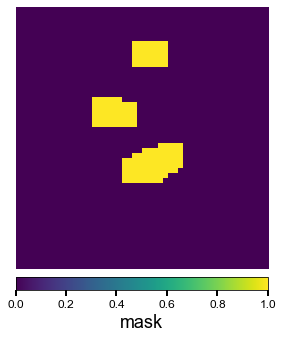

<Figure size 432x288 with 0 Axes>

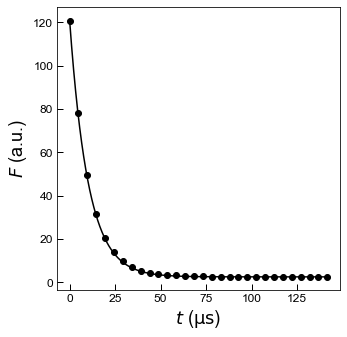

<Figure size 432x288 with 0 Axes>

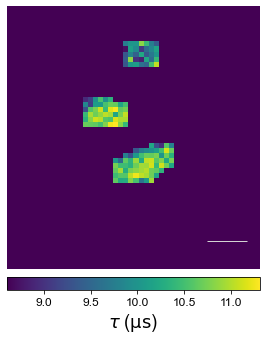

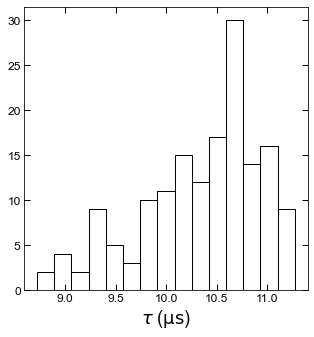

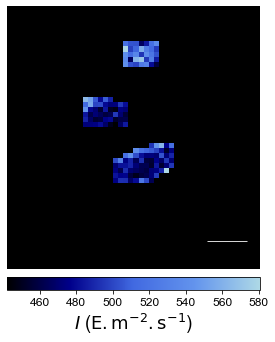

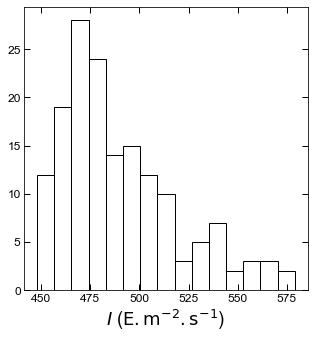

In [21]:




k=5
name = os.path.split(file)[1][:-4] + "_%d"%k
plt.close('all')
K = 5
D = 3
volume, Name, PixelDwellTime, Zoom = LIF_ImgAndInfo(file, k)
u, dx, dy = volume.shape
print(dx, dy)
volume = volume[:,100:256, 50:200]

time = np.linspace(0, len(video)-1, len(video))*dwell_time #generate time array from framerate
v_ref = np.mean(volume[0:K], axis = 0)
mask = v_ref>np.mean(v_ref)


im_ref = downscale_local_mean(v_ref, (D, D))


p.set_figure()
plt.axis("off")
image = plt.imshow(im_ref, cmap = "gray")
H, L = im_ref.shape
scale = H//6
rec = matplotlib.patches.Rectangle((H-H//4, L-L//11), scale, L//70, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)


plt.savefig(p.save_folder + "/confocalX_intensity" + p.extension)


if k in [5, 2, 28]:

    im_ref = downscale_local_mean(np.mean(volume[0:K], axis = 0), (D, D))

    threshold = skimage.filters.threshold_li(im_ref) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
    #select it from the image that best matches a mask, and copy the corresponding function name printed above

    mask = im_ref>threshold
    mask = binary_opening(mask,  np.ones((k,k)))

    fig = p.image_scale(mask, label = 'mask')

    p.save_name = name  +  "_mask_ref"
    p.saving(fig)

else:

    dp = 290/dx*1e-6
    S = 200*1e-6/dp + 1
    mask = np.zeros((im_ref.shape))
    V = 2*D
    mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1

    mask = mask.astype(bool)
    p.save_name = name  +  "_mask_ref"
    p.saving(fig)

video = np.copy(volume)
video_downscaled = []
for i in range(video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]

video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)
print(mask.shape)
print(video_downscaled.shape)
to_evaluate = video_downscaled[:,mask.flatten()]

fig = p.set_figure("%d", "%d")    
x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
y= np.mean(to_evaluate, axis = 1)

params = simple_tau(y, x, sample_rate = 0)
print(params[1])

x2 = np.linspace(x.min(), x.max(), 1024)
plt.plot(x2, exp_decay(params, x2), "k")

plt.plot(x, y, "ok",
        label = "dwell_time: %0.1e s "%(dwell_time))
plt.xlabel(r"$t$ ($\mathrm{\mu s}$)")
plt.ylabel("$F$ (a.u.)")
p.save_name = name + "_mean_time_response"
p.saving(fig)

start = 0
stop = -1
"""
for i in range(to_evaluate.shape[1]):
            print(params[1])
            plt.figure()
            y, x = to_evaluate[start:stop,i], time[start:stop]
            params = simple_tau(y, x, sample_rate =  0)
            plt.plot(x, y)
            plt.plot(x, exp_decay(params, x), 'k')
            plt.show()
"""

tau_lists = Parallel(n_jobs = -1 )(simple_tau_parallel(to_evaluate[start:stop,i], time[start:stop], sample_rate = 1/dwell_time) for i in tqdm(range(to_evaluate.shape[1])))

plt.set_cmap('viridis')

tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480
#I, dis = plot_map(tau_480*1e6, crop(tau_480_map*1e6, 0.9, 1),  name + "_tau_pred", tau=True, limits = (np.quantile(tau_480*1e6, 0), np.quantile(tau_480*1e6, 0.995)))
I, dis = plot_map(tau_480*1e6, tau_480_map*1e6,  name + "_tau_pred", tau=True, limits = (np.quantile(tau_480*1e6, 0), np.quantile(tau_480*1e6, 0.995)))

I_480 = (1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

#I, dis = plot_map(I_480, crop(I_480_map, 0.9, 1),  name + "_intensity_pred", limits = (np.quantile(I_480, 0), np.quantile(I_480, 0.995)))
I, dis = plot_map(I_480, I_480_map, name + "_intensity_pred", limits = (np.quantile(I_480, 0), np.quantile(I_480, 0.995)))



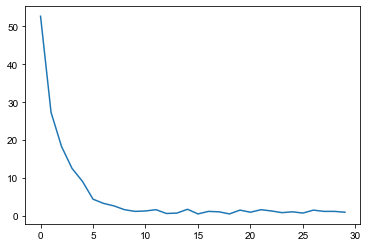

In [22]:
plt.plot(to_evaluate[:,10])

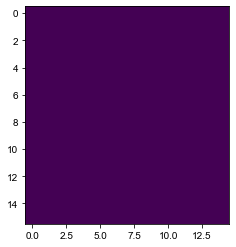

In [19]:
threshold = skimage.filters.threshold_otsu(im_ref) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
#select it from the image that best matches a mask, and copy the corresponding function name printed above

mask = im_ref>threshold
mask = binary_opening(mask,  np.ones((k,k)))
plt.imshow(mask)

9.428904696003029
9.679052692130561
9.681747042224499
10.474491874509892
10.08077878778192
9.440432169758417
9.085373582968838
8.432535042937062
9.803737389173723
9.564967697821592
8.745479416143965
9.244051472245399
9.519101106916139
9.832636019515697
9.031606993915004
9.488973015212544
9.144663820886127
9.882748246525612
9.036740214096682
9.369202282296579
9.688814537750897
9.081890577249066
10.482912096712607
8.693108287439026
8.55635844025134
9.860824694242968
9.251323704844895
10.065460198778313
9.019499041888665
9.69884557257478
9.775822119098516


C:\Users\Alienor\AppData\Local\Temp\ipykernel_16496\1754934128.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


9.297887237296937
9.187029396270283
10.162933587081042
10.675106121856205
8.638662341484869
8.824105138378656
9.654890044416055
10.179142055788333
9.622340389762567
10.010395655586928
9.525473521859913
8.780090025123158
9.774415818259898
9.738910741653923
10.173222274064706
10.346097671101438
10.314830137916209
9.867925191964503
10.147123845836699
8.969495658501266
10.204930604864185
10.388293233417201
10.730589379929684
10.084357385946916
10.808581553817065
10.898210261670162
10.286516041038325
10.368128834554078
10.08369588029597
10.590653329751323
10.352304768218609
10.50364644684789
10.66318060050755
10.576946780515295
9.85438553076604
10.391741352107703
10.690119567988798
9.99349898966123
10.454317631031127
10.736398680671746
10.66095952399119
10.251772030632411
10.193381112108138
10.777329649345052
10.604316346868606
10.600262914130072
10.328485347858292
10.31520594719862
10.277567118302933
10.158219540738878
10.448143239209971
10.874293844855691
11.042759414297409
10.46873537283

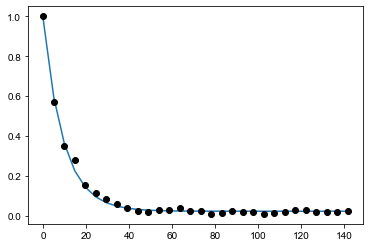

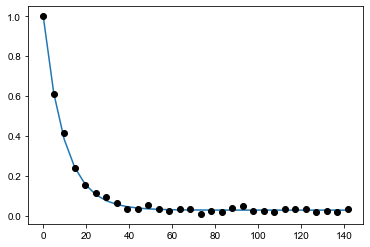

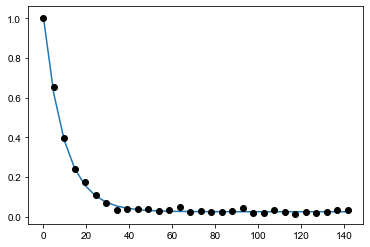

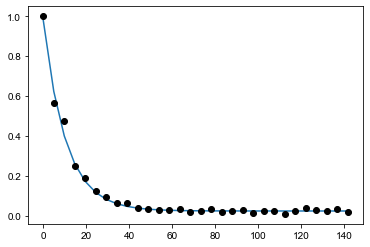

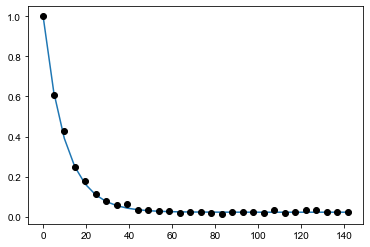

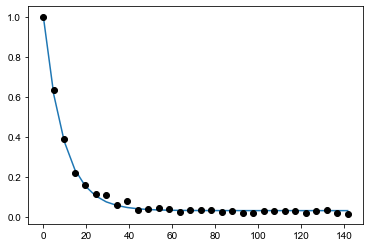

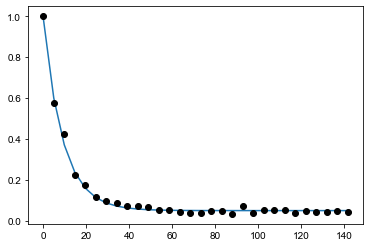

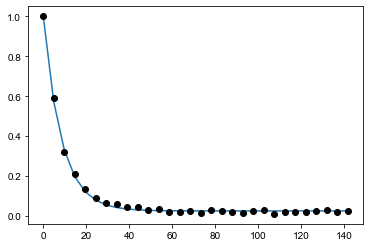

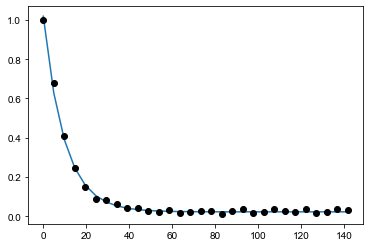

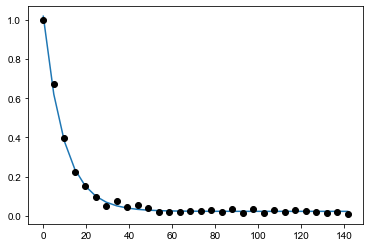

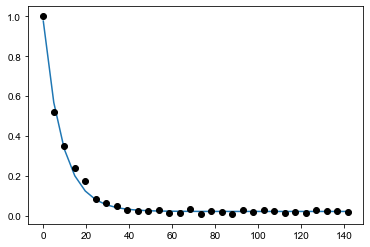

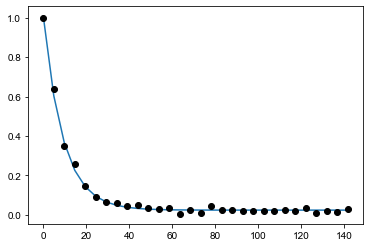

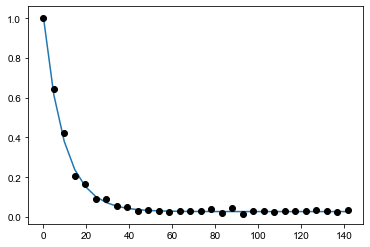

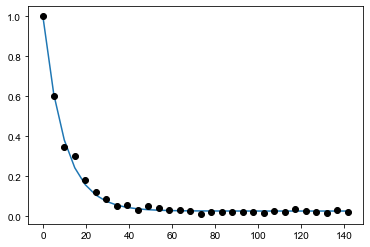

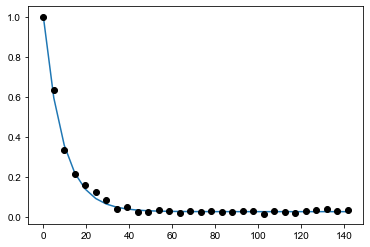

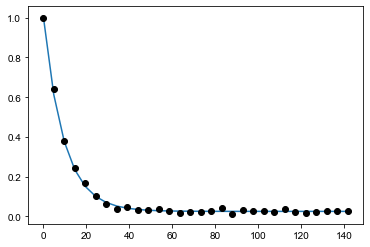

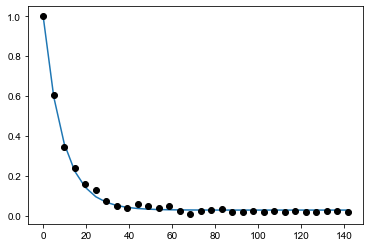

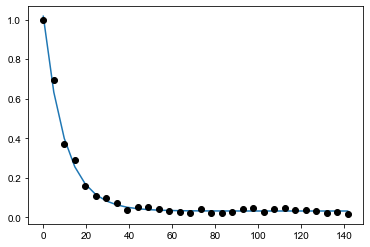

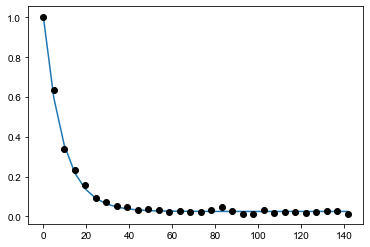

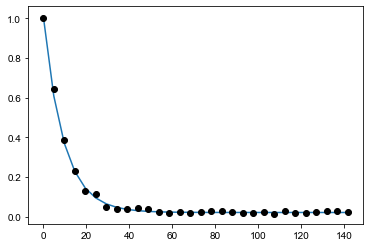

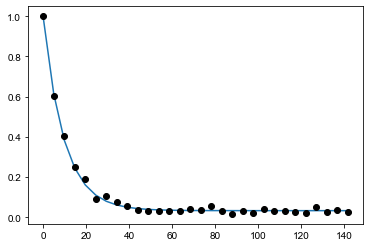

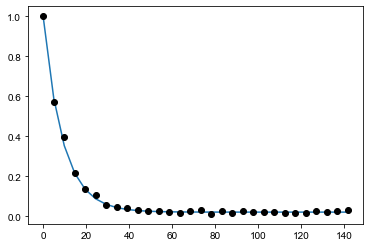

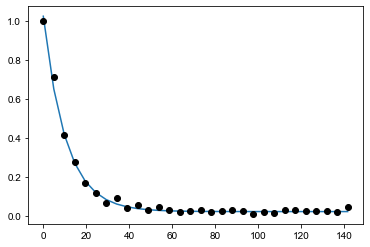

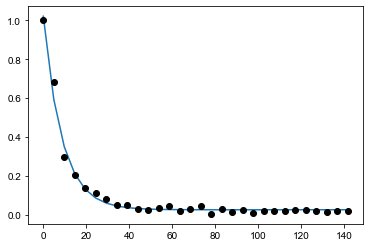

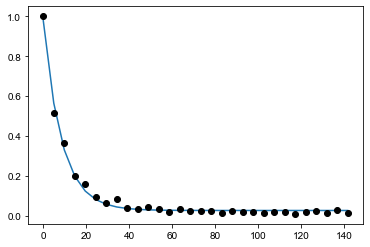

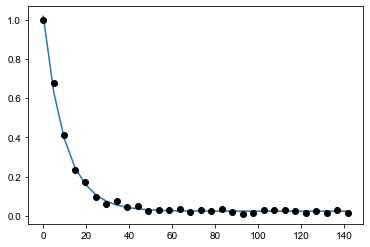

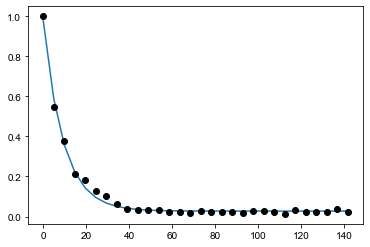

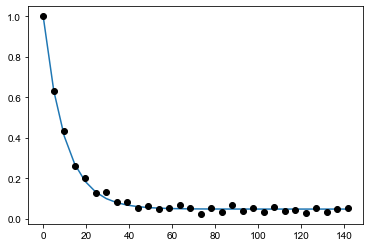

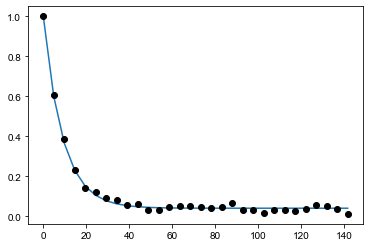

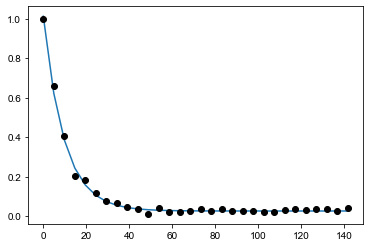

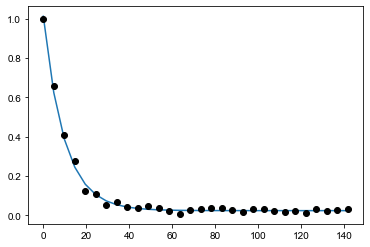

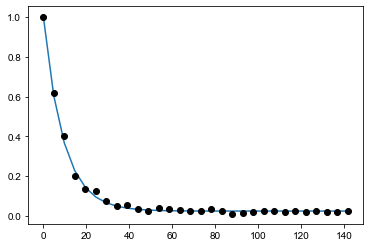

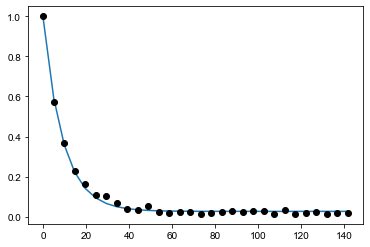

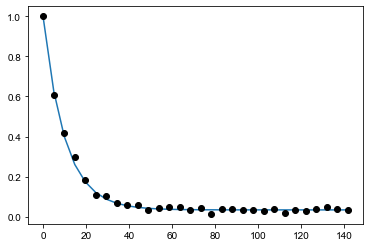

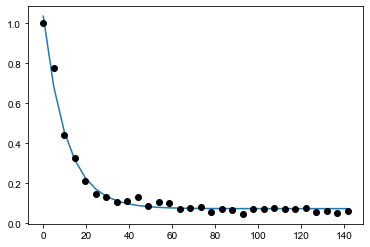

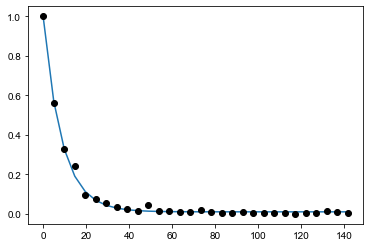

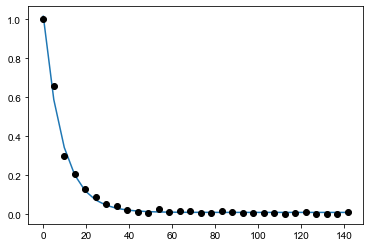

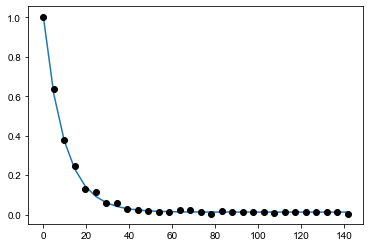

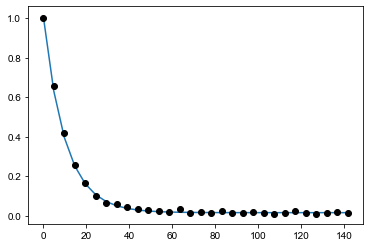

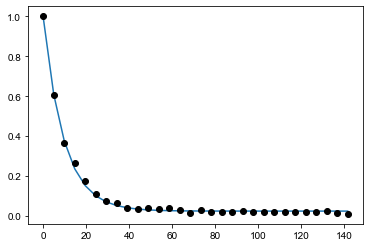

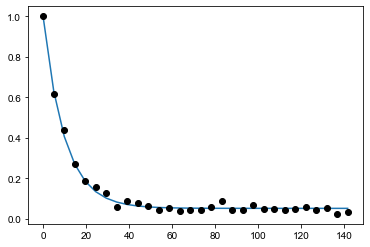

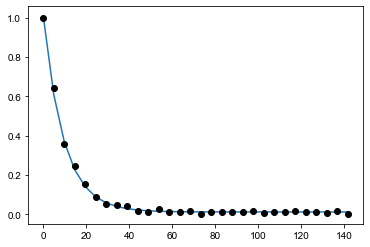

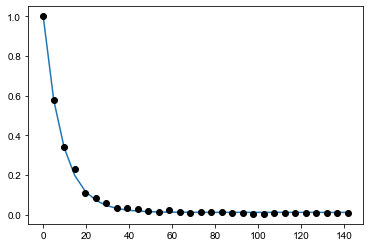

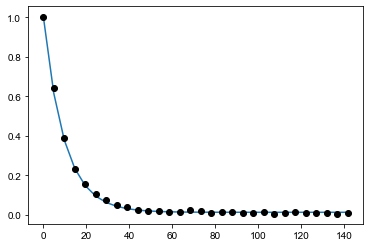

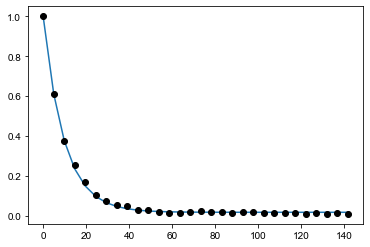

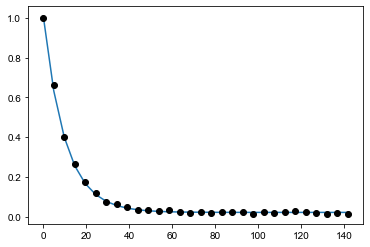

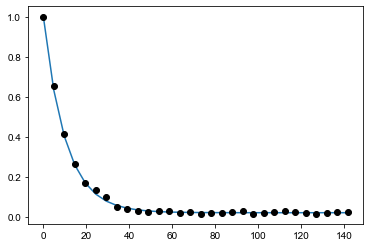

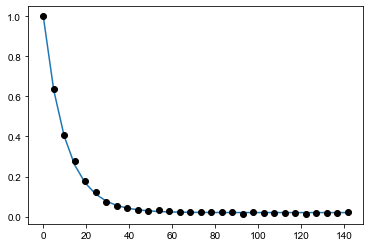

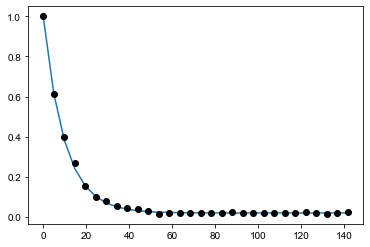

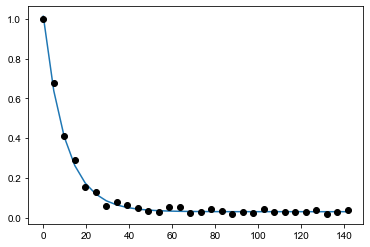

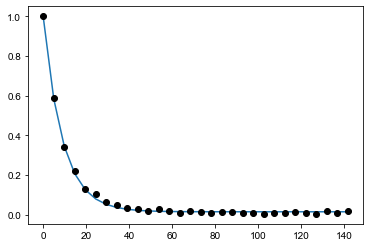

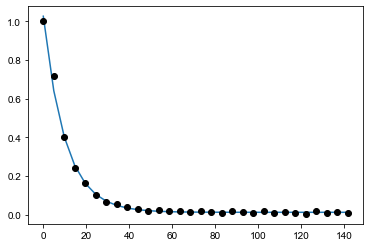

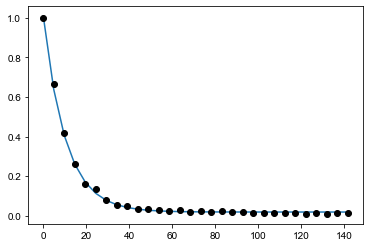

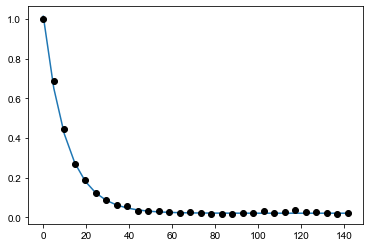

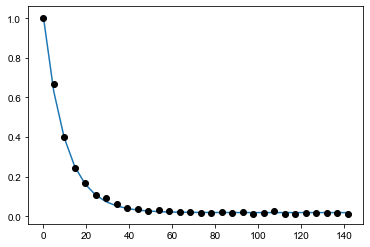

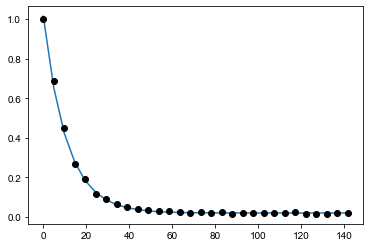

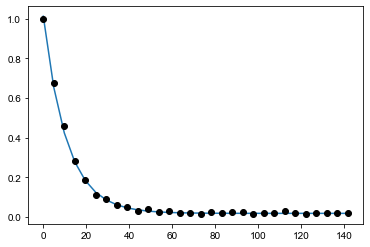

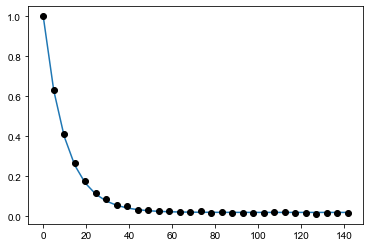

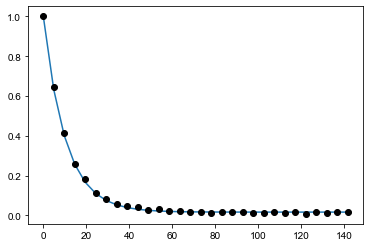

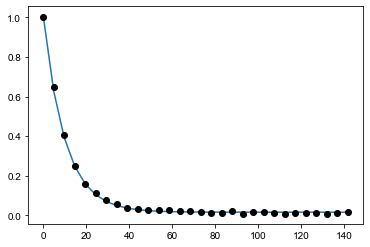

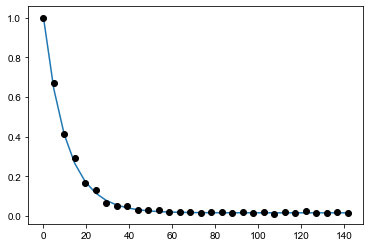

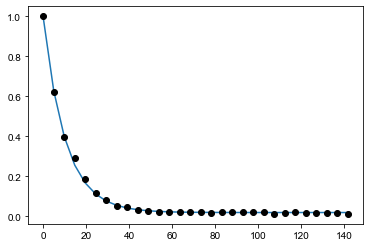

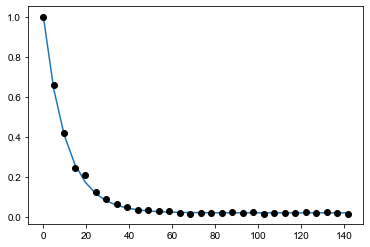

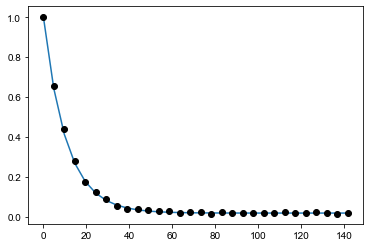

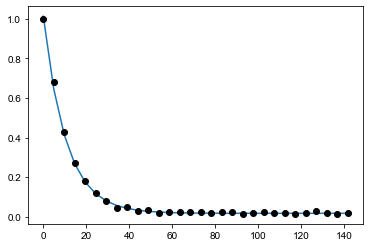

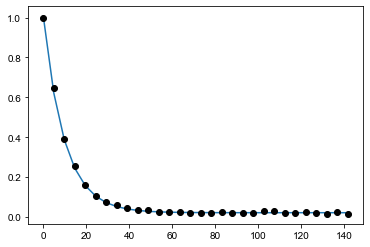

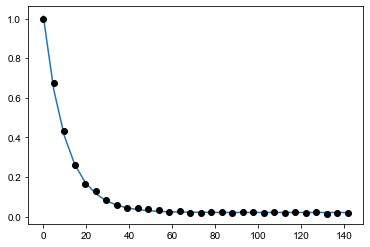

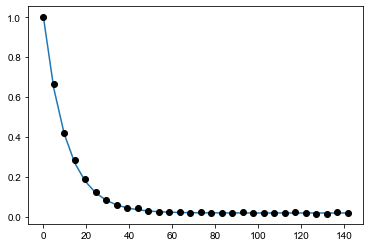

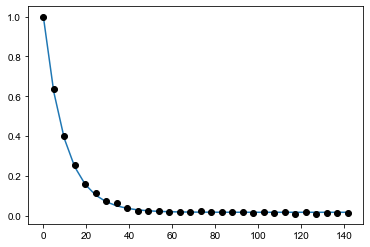

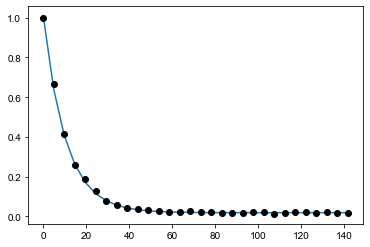

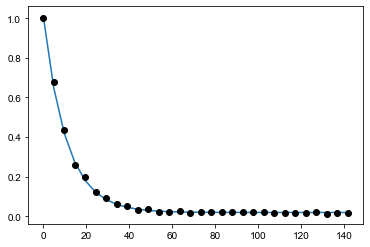

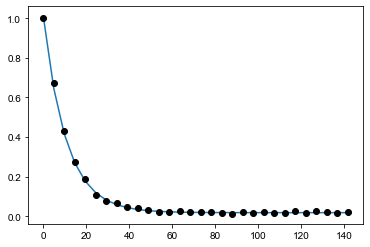

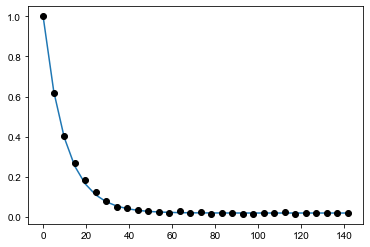

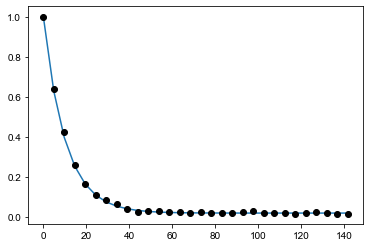

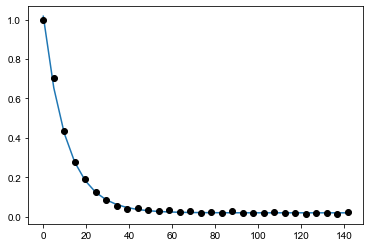

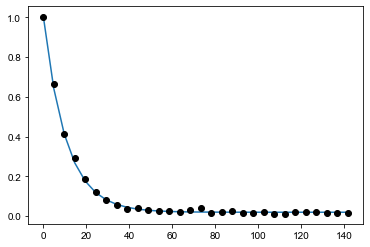

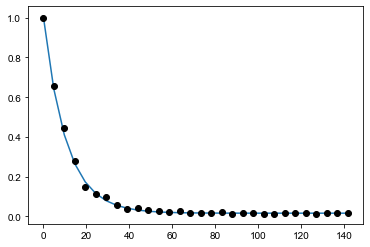

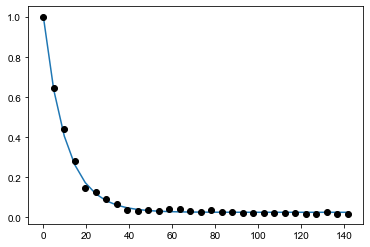

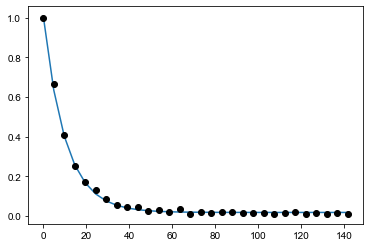

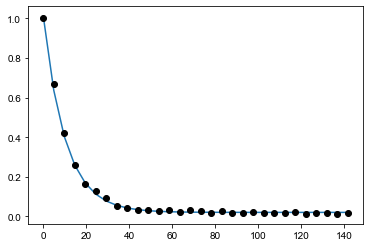

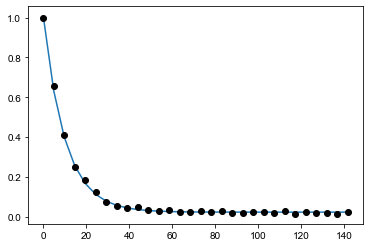

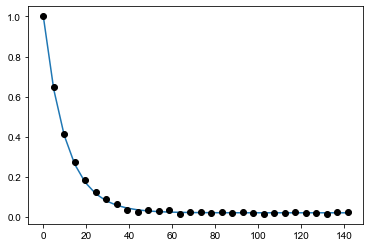

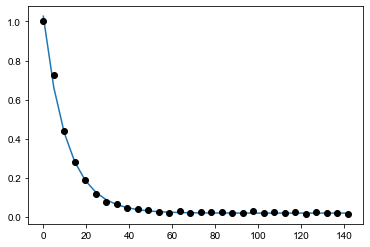

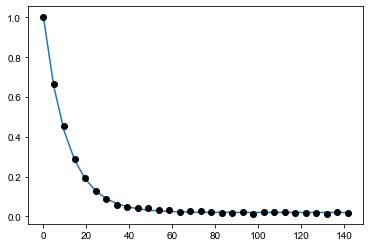

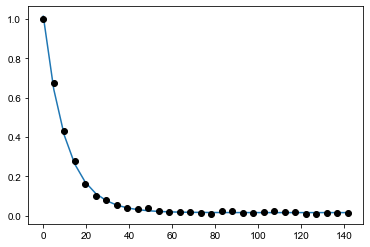

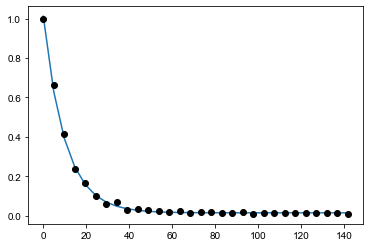

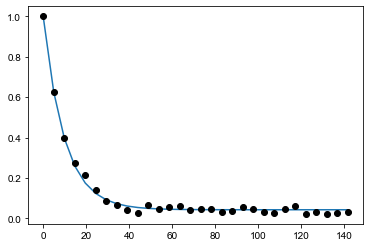

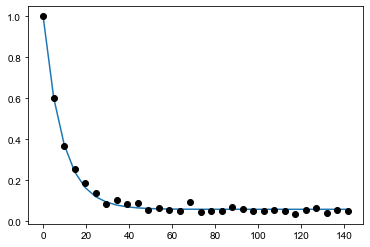

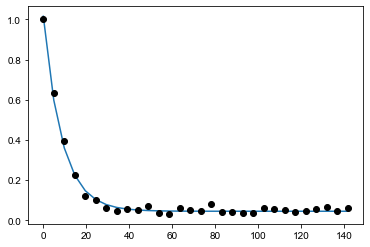

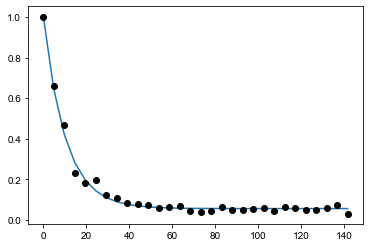

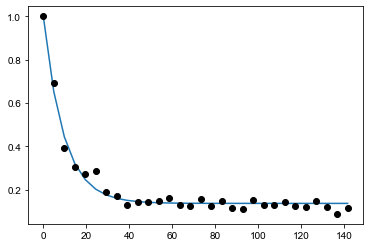

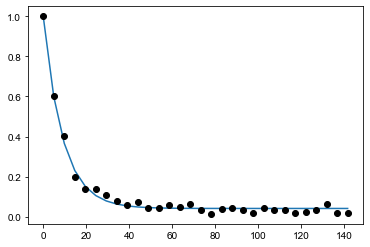

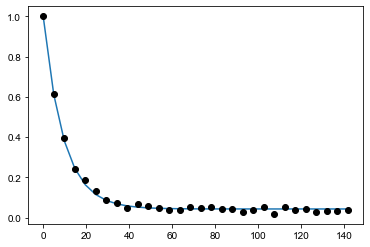

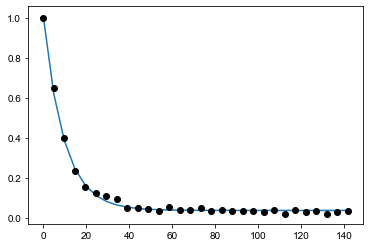

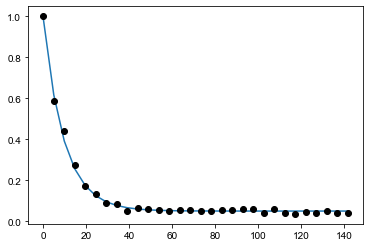

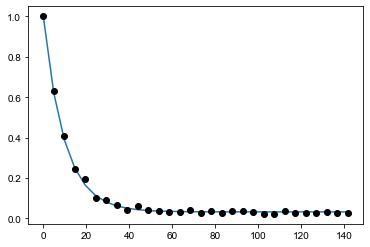

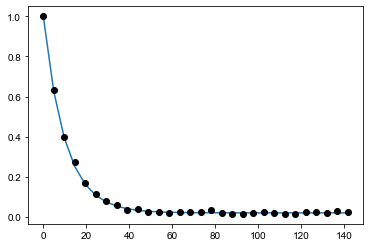

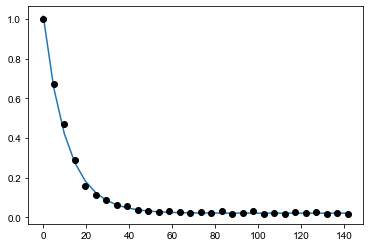

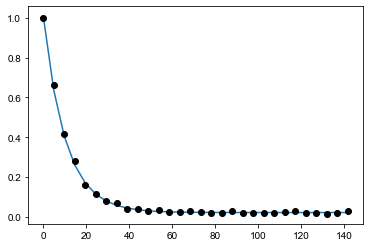

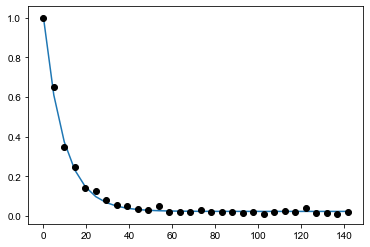

In [28]:
for i in range(0, 100):
    plt.figure()
    ax = plt.gca()
    x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
    y= to_evaluate[:,i]
    y/=y[0]

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])
    ax.plot(x, exp_decay(params, x))
    ax.plot(x, y, "ok",
            label = "dwell_time: %0.1e s "%(dwell_time))